# Demo 3: a demo for comparing classification-based decoding and RSA
Here is a demo based on the data of Bae&Luck's work in 2018. All demo data are based on their Experiment 2's data. You can find more details about the experiment and data information in their paper: Bae, G.Y., Luck, S.J. (2018). Dissociable decoding of spatial attention and working memory from eeg oscillations and sustained potentials. The Journal of Neuroscience, 38(2), 409-422.

In [1]:
import os
import sys
import zipfile
import numpy as np
import scipy.io as sio
import h5py
from sklearn.svm import SVC
from neurora.stuff import permutation_test
from sklearn.metrics import accuracy_score
from six.moves import urllib
import matplotlib.pyplot as plt
from neurora.rdm_cal import eegRDM
from neurora.rsa_plot import plot_rdm, plot_tbytsim_withstats
from neurora.corr_cal_by_rdm import rdms_corr

url = 'https://attachment.zhaokuangshi.cn/BaeLuck_2018jn_data_ERP_5subs.zip'
filename = 'BaeLuck_2018jn_data_ERP_5subs.zip'
data_dir = 'data/'
classification_results_dir = 'classification_results/'
ctrsa_results_dir = 'rsa_results/'
filepath = data_dir + filename

## Section 1: Download the data

In [2]:
# Download the data

def show_progressbar(str, cur, total=100):

    percent = '{:.2%}'.format(cur / total)
    sys.stdout.write('\r')
    sys.stdout.write(str + ": [%-100s] %s" % ('=' * int(cur), percent))
    sys.stdout.flush()

def schedule(blocknum,blocksize,totalsize):

    if totalsize == 0:
        percent = 0
    else:
        percent = blocknum * blocksize / totalsize
    if percent > 1.0:
        percent = 1.0
    percent = percent * 100
    show_progressbar("Downloading", percent)

exist = os.path.exists(filepath)
if exist == False:
    os.makedirs(data_dir)
    urllib.request.urlretrieve(url, filepath, schedule)
    print('Download completes!')
elif exist == True:
    print('Data already exists!')

# unzip the data

def unzipfile(filepath, data_dir):

    with zipfile.ZipFile(filepath, 'r') as zip:
        zip.extractall(data_dir)
    print("Unzip completes!")

unzipfile(filepath, data_dir)

Data already exists!
Unzip completes!


## Section 2: Classification-based Decoding

In [3]:
# data preprocessing for classification-based decoding

# sub_ids
subs = ["201", "202", "203", "204", "205"]

exist = os.path.exists(data_dir + 'data_for_classification/ERP/')
if exist == False:
    os.makedirs(data_dir + 'data_for_classification/ERP/')

for sub in subs:
    data = sio.loadmat(data_dir + "data/ERP" + sub + ".mat")["filtData"][:, :, 250:]
    print(data.shape)
    # data.shape: n_trials, n_channels, n_times

    ori_label = np.loadtxt(data_dir + "labels/ori_" + sub + ".txt")[:, 1]
    pos_label = np.loadtxt(data_dir + "labels/pos_" + sub + ".txt")[:, 1]

    ori_subdata500 = np.zeros([16, 40, 27, 500], dtype=np.float)
    pos_subdata500 = np.zeros([16, 40, 27, 500], dtype=np.float)

    ori_labelindex = np.zeros([16], dtype=np.int)
    pos_labelindex = np.zeros([16], dtype=np.int)

    for i in range(640):
        label = int(ori_label[i])
        ori_subdata500[label, ori_labelindex[label]] = data[i]
        ori_labelindex[label] = ori_labelindex[label] + 1
        label = int(pos_label[i])
        pos_subdata500[label, pos_labelindex[label]] = data[i]
        pos_labelindex[label] = pos_labelindex[label] + 1

    ori_subdata = np.zeros([16, 40, 27, 100], dtype=np.float)
    pos_subdata = np.zeros([16, 40, 27, 100], dtype=np.float)

    for t in range(100):
        ori_subdata[:, :, :, t] = np.average(ori_subdata500[:, :, :, t * 5:t * 5 + 5], axis=3)
        pos_subdata[:, :, :, t] = np.average(pos_subdata500[:, :, :, t * 5:t * 5 + 5], axis=3)

    f = h5py.File(data_dir + "data_for_classification/ERP/" + sub + ".h5", "w")
    f.create_dataset("ori", data=ori_subdata)
    f.create_dataset("pos", data=pos_subdata)
    f.close()

# aftering the preprocessing above,
# we can obtain ERP data of orientation and position for each subject
# each subject's orientation ERP data's shape is [16, 40, 27, 100]
# 16: the number of conditions (here means 16 different orientation degrees)
# 40: the number of trials
# 27: the number of channels
# 100: the number of time-points (from -500 ms to 1500 ms, sample rate: 50 Hz)

# Linear-SVM decoding

exist = os.path.exists(classification_results_dir)
if exist == False:
    os.makedirs(classification_results_dir)

# orientation decoding
print("\nOrientation Decoding!")
subindex = 0
if os.path.exists(classification_results_dir + "ERP_ori.h5"):
    os.remove(classification_results_dir + "ERP_ori.h5")
f = h5py.File(classification_results_dir + "ERP_ori.h5", "w")
total = len(subs) * 10 * 3 * 100
for sub in subs:
    fdata = h5py.File(data_dir + "data_for_classification/ERP/" + sub + ".h5", "r")
    data = np.array(fdata["ori"])
    fdata.close()
    acc = np.zeros([10, 100, 3], dtype=np.float)
    for k in range(10):
        index_trials = np.array(range(40))
        shuffle = np.random.permutation(index_trials)
        newdata = data[:, shuffle[:39]]
        block_data = np.zeros([3, 16, 27, 100], dtype=np.float)
        for i in range(3):
            block_data[i] = np.average(newdata[:, i * 13:i * 13 + 13], axis=1)
        y_train = np.zeros([2 * 16], dtype=np.int)
        for i in range(2):
            for j in range(16):
                y_train[i * 16 + j] = j
        y_test = np.zeros([16], dtype=np.int)
        for i in range(16):
            y_test[i] = i
        for i in range(3):
            x_test = block_data[i]
            x_train = np.zeros([2, 16, 27, 100], dtype=np.float)
            index = 0
            for j in range(3):
                if j != i:
                    x_train[index] = block_data[j]
                    index = index + 1
            x_train = np.reshape(x_train, [2 * 16, 27, 100])
            for t in range(100):
                x_train_t = x_train[:, :, t]
                x_test_t = x_test[:, :, t]
                svm = SVC(kernel='linear', decision_function_shape='ovr')
                svm.fit(x_train_t, y_train)
                y_pred = svm.predict(x_test_t)
                acc[k, t, i] = accuracy_score(y_test, y_pred)
    subindex = subindex + 1
    f.create_dataset(sub, data=np.average(acc, axis=(0, 2)))
f.close()

# orientation decoding
print("\nPosition Decoding!")
subindex = 0
f = h5py.File(classification_results_dir + "ERP_pos.h5", "w")
total = len(subs) * 10 * 3 * 100
for sub in subs:
    fdata = h5py.File(data_dir + "data_for_classification/ERP/" + sub + ".h5", "r")
    data = np.array(fdata["pos"])
    fdata.close()
    acc = np.zeros([10, 100, 3], dtype=np.float)
    for k in range(10):
        index_trials = np.array(range(40))
        shuffle = np.random.permutation(index_trials)
        newdata = data[:, shuffle[:39]]
        block_data = np.zeros([3, 16, 27, 100], dtype=np.float)
        for i in range(3):
            block_data[i] = np.average(newdata[:, i * 13:i * 13 + 13], axis=1)
        y_train = np.zeros([2 * 16], dtype=np.int)
        for i in range(2):
            for j in range(16):
                y_train[i * 16 + j] = j
        y_test = np.zeros([16], dtype=np.int)
        for i in range(16):
            y_test[i] = i
        for i in range(3):
            x_test = block_data[i]
            x_train = np.zeros([2, 16, 27, 100], dtype=np.float)
            index = 0
            for j in range(3):
                if j != i:
                    x_train[index] = block_data[j]
                    index = index + 1
            x_train = np.reshape(x_train, [2 * 16, 27, 100])
            for t in range(100):
                x_train_t = x_train[:, :, t]
                x_test_t = x_test[:, :, t]
                svm = SVC(kernel='linear', decision_function_shape='ovr')
                svm.fit(x_train_t, y_train)
                y_pred = svm.predict(x_test_t)
                acc[k, t, i] = accuracy_score(y_test, y_pred)
    subindex = subindex + 1
    f.create_dataset(sub, data=np.average(acc, axis=(0, 2)))
f.close()

(640, 27, 500)
(640, 27, 500)
(640, 27, 500)
(640, 27, 500)
(640, 27, 500)

Orientation Decoding!

Position Decoding!


## Section 3: Plot the classification-based decoding results

Orientation Classification-based Decoding Results!


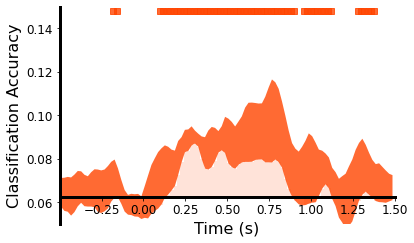

Position Classification-based Decoding Results!


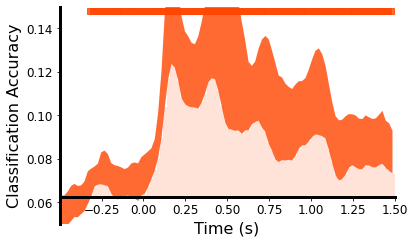

In [4]:
# plot the classification-based decoding results

# a function for plotting the time-by-time decoding results
def plot_tbytresults(decoding_results_dir, subs):
    f = h5py.File(decoding_results_dir, "r")
    nsubs = len(subs)
    rlts = np.zeros([nsubs, 100], dtype=np.float)
    subindex = 0
    for sub in subs:
        rlts[subindex] = np.array(f[sub])
        for t in range(100):
            if t <= 1:
                rlts[subindex, t] = np.average(rlts[subindex, :t + 3])
            if t > 1 and t < 98:
                rlts[subindex, t] = np.average(rlts[subindex, t - 2:t + 3])
            if t >= 98:
                rlts[subindex, t] = np.average(rlts[subindex, t - 2:])
        subindex = subindex + 1
    f.close()

    avg = np.average(rlts, axis=0)
    err = np.zeros([100], dtype=np.float)
    for t in range(100):
        err[t] = np.std(rlts[:, t], ddof=1) / np.sqrt(nsubs)

    ps = np.zeros([100], dtype=np.float)
    chance = np.full([16], 0.0625)
    for t in range(100):
        ps[t] = permutation_test(rlts[:, t], chance)
        if ps[t] < 0.05 and avg[t] > 0.0625:
            plt.plot(t * 0.02 - 0.5, 0.148, "s", color="orangered", alpha=0.8)
            xi = [t * 0.02 - 0.5, t * 0.02 + 0.02 - 0.5]
            ymin = [0.0625]
            ymax = [avg[t] - err[t]]
            plt.fill_between(xi, ymax, ymin, facecolor="orangered", alpha=0.15)

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0.0625))
    x = np.arange(-0.5 + 0.008, 1.5 + 0.008, 0.02)
    plt.fill_between(x, avg + err, avg - err, facecolor="orangered", alpha=0.8)
    plt.ylim(0.05, 0.15)
    plt.xlim(-0.5, 1.5)
    plt.xticks([-0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
    plt.tick_params(labelsize=12)
    plt.xlabel("Time (s)", fontsize=16)
    plt.ylabel("Classification Accuracy", fontsize=16)
    plt.show()

# plot orientation decoding results
print("Orientation Classification-based Decoding Results!")
plot_tbytresults(classification_results_dir + "ERP_ori.h5", subs)

# plot position decoding results
print("Position Classification-based Decoding Results!")
plot_tbytresults(classification_results_dir + "ERP_pos.h5", subs)

## Section 4: RSA-based Decoding

201
202
203
204
205
Loading data of sub201
Loading data of sub202
Loading data of sub203
Loading data of sub204
Loading data of sub205

Calculate the Orientation RDMs!

Calculate the Position RDMs!
Coding RDM!
1


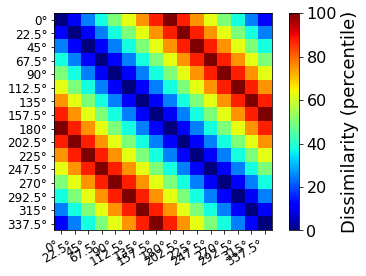


Calculate the Similarities of Orientation!
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.11262181 0.15196211 0.07535903 0.07622689 0.18047055 0.07441325
 0.11698965 0.07454578 0.09778885 0.2258557  0.1303254  0.2374368
 0.08885518 0.231045   0.10913562 0.11291455 0.0985106  0.03579329
 0.19972

 0.30492882 0.04469304 0.14209405 0.28636322 0.21856647 0.15075508]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.06410887 0.08522704 0.16627017 0.06926838 0.1576686  0.0742262
 0.07152008 0.08360466 0.18500655 0.08598948 0.06454568 0.17509685
 0.13524144 0.16905064 0.14000429 0.16143868 0.1639

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.11768106 0.15695508 0.07585145 0.17064005 0.4318945  0.18219121
 0.19064549 0.20387394 0.14194528 0.41351057 0.2989572  0.93158117
 0.27773476 0.18568933 0.08311271 0.34678767 0.18637505 0.37760072
 0.6644854  0.340628   0.40713747 0.36959589 0.29622646 0.77230867
 0.30380628 0.72025409 0.24229527 0.1228443  0.11040676 0.08555868
 0.11638599 0.17284078 0.21047407 0.13425176 0.27177806 0.05825395
 0.23459286 0.40714266 1.36090913 0.53197969 0.46825474 0.25602725
 0.08326686 0.34205341 0.11242294 0.16991192 0.16223581 0.07197388
 0.37052295 0.26446841 1.13141769 0.47402409 0.36004322 0.14341365
 0.34247157 0.19850886 0.1649676  0.10650922 0.1189896  0.22931182
 0.4044439  1.24158135 0.63668036 0.53377192 0.30005598 0.33998236
 0.15950041 0.52813703 0.18231913 0.19971087 0.55806683 1.52994507
 0.80790465 0.75777523 0.46267839 0.16960693 0.29559621 0.12415499
 0.38969682 0.15330419 1.16380378 0.68253578 0.5452032 

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.20272517 0.13515705 0.14313664 0.17615054 0.3474801  0.30895203
 0.26461328 0.19421587 0.17363269 0.34581953 0.20835385 0.27401811
 0.38422127 0.18743818 0.17111495 0.13903416 0.17298729 0.19855488
 0.31336495 0.49265999 0.26481829 0.26369626 0.1137

 0.11160703 0.07734651 0.13547255 0.10750113 0.13530146 0.18668621]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.12995143 0.11868742 0.06382118 0.07610685 0.08453982 0.08975314
 0.06407456 0.12091664 0.09956445 0.06631814 0.07220252 0.06644121
 0.0838953  0.11372546 0.06732634 0.081231   0.066

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.2608513  0.34806015 0.67020948 1.0652266  0.95904248 0.98463272
 0.91919091 0.67499972 0.30838899 0.60958022 0.39474782 0.26828764
 0.42498662 0.34196583 0.21947321 0.19111625 0.72562769 1.18835276
 1.05331615 1.07956543 0.99161704 0.77824134 0.4107

 0.21300505 0.17506813 0.13648034 0.23481048 0.41091725 0.13787994]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.11000694 0.11844073 0.11142953 0.24829562 0.18831165 0.14335335
 0.34808313 0.1957261  0.22949954 0.12263384 0.19045091 0.15473187
 0.3016343  0.18783512 0.2254345  0.08430772 0.106

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.09770205 0.13467535 0.19491034 0.09144246 0.12027907 0.1955244
 0.10968402 0.13740993 0.20816022 0.16310514 0.1799036  0.12477786
 0.27629498 0.10494637 0.15051289 0.1836648  0.3162787  0.08149243
 0.11667087 0.13005442 0.08000148 0.19570403 0.26268975 0.18570358
 0.35099538 0.12841894 0.33047429 0.10116703 0.26032808 0.25113673
 0.10695081 0.13859543 0.17742273 0.11266557 0.05578875 0.2125974
 0.17105544 0.16141141 0.11483992 0.19226433 0.05010484 0.15991376
 0.27368131 0.16218105 0.34331885 0.23308681 0.20211522 0.33366537
 0.21761415 0.15846338 0.2469284  0.30731662 0.21514007 0.05704556
 0.0894215  0.08833831 0.04243331 0.09250874 0.17264445 0.1775712
 0.26583389 0.11590784 0.28281321 0.05777435 0.2017635  0.14486751
 0.10872506 0.06953978 0.23406161 0.12298476 0.18854809 0.09761747
 0.16100103 0.04677179 0.13274848 0.10101174 0.14865315 0.40003277
 0.18681041 0.43953135 0.12409304 0.33415619 0.11449307 0.

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.48064491 0.7833007  0.33062435 0.4702285  0.68661512 0.70404729
 0.72497995 0.56432708 0.31175767 0.27258888 0.38678882 0.31842625
 0.30777951 0.29310849 0.22256884 0.21585256 0.35049225 0.16893783
 0.14187523 0.15197776 0.14946134 0.18658262 0.7850

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.13761471 0.24156011 0.25066144 0.23502762 0.11562838 0.32818276
 0.1035027  0.33419956 0.19521225 0.21068734 0.08843452 0.09261886
 0.26003183 0.25061076 0.26770907 0.1280121  0.23105622 0.25278395
 0.1080449  0.19597073 0.0915576  0.11272263 0.35607085 0.10440302
 0.14952155 0.11876717 0.09007335 0.1720355  0.10312794 0.30857049
 0.30670809 0.25195603 0.14081771 0.11675543 0.19113636 0.48677048
 0.17541799 0.19071632 0.13652491 0.05294631 0.07837116 0.07135271
 0.1511574  0.15251739 0.27817466 0.22652666 0.44980011 0.30586742
 0.4775303  0.22722259 0.14838586 0.36073905 0.24640302 0.33495058
 0.16811638 0.25112146 0.29369101 0.38887412 0.31755671 0.44398997
 0.31023793 0.12888384 0.31807673 0.18347136 0.3672486  0.31889248
 0.10070027 0.2473225  0.1506513  0.21221972 0.10485397 0.09273303
 0.24140227 0.23796688 0.27652949 0.2697275  0.26423181 0.59162577
 0.27571011 0.32486342 0.22486569 0.13606436 0.11913366

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.22195395 0.35344405 0.27965756 0.16101865 0.15787372 0.08395073
 0.07349508 0.17117796 0.23253382 0.23307377 0.16040249 0.10380225
 0.09696938 0.18740592 0.20391233 0.36937925 0.26643468 0.15000729
 0.28943214 0.28748727 0.22251357 0.25304899 0.43197131 0.22218416
 0.32983026 0.26318516 0.35988545 0.38720468 0.25512168 0.45304813
 0.34324167 0.55252967 0.45665711 0.32414328 0.17465081 0.66450078
 0.18216897 0.39763574 0.22242853 0.29820594 0.48542662 0.17592898
 0.14956011 0.41195472 0.25163206 0.34053809 0.29560144 0.60493879
 0.24832565 0.55401284 0.29900967 0.40104582 0.43810311 0.27074184
 0.22291936 0.16485546 0.18971972 0.16349875 0.31762404 0.14629258
 0.32122372 0.15698401 0.29381834 0.26598014 0.16852274 0.1601658
 0.18127152 0.31991529 0.1942861  0.36495639 0.08835739 0.27992527
 0.30854103 0.20714644 0.40581356 0.12928147 0.2421041  0.19676092
 0.29731768 0.22187017 0.10246428 0.19012742 0.18441093 

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.090135   0.10695835 0.17812424 0.0576063  0.07324475 0.122972
 0.11013465 0.06850695 0.19120218 0.06903215 0.14823367 0.17146757
 0.14035613 0.05439356 0.10190196 0.04808262 0.06725157 0.05563635
 0.14586868 0.02630795 0.06741472 0.04679898 0.057503

 0.43143688 0.17703932 0.22577233 0.21025477 0.22029736 0.12514829]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.12293067 0.2641635  0.19835129 0.16168283 0.26211322 0.70054865
 0.18813609 0.11815426 0.24448494 0.12841171 0.16012062 0.21550412
 0.18842508 0.06809055 0.13627292 0.23933346 0.261

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.09843591 0.04276142 0.08743932 0.03181541 0.26720802 0.0521177
 0.09136517 0.05550486 0.03895924 0.08069672 0.15862143 0.04980406
 0.05312922 0.06401468 0.43145716 0.08691982 0.25021142 0.12958996
 0.28333929 0.12052041 0.06438605 0.16098471 0.17202704 0.16757693
 0.23263265 0.14190751 0.17696661 0.12816863 0.35232628 0.09318904
 0.04498942 0.21400021 0.05803913 0.08538094 0.0975335  0.07048294
 0.07556914 0.17437832 0.06774107 0.09379222 0.06021499 0.33660619
 0.08012945 0.33573844 0.13206396 0.22417119 0.16683651 0.0580143
 0.08083411 0.29557022 0.1104154  0.12363028 0.07740557 0.35902028
 0.18809093 0.04269506 0.11120526 0.05400546 0.02808879 0.03483499
 0.11993586 0.04991611 0.04316809 0.06740579 0.4630211  0.15758127
 0.27675588 0.16748031 0.21670097 0.15582344 0.08010888 0.24328566
 0.20517276 0.27320874 0.67253439 0.13069999 0.03879518 0.07185587
 0.07191315 0.09415836 0.06221182 0.0439771  0.12700727 0

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.13216681 0.14447807 0.40221561 0.48516446 0.56369122 0.76470472
 0.77010706 0.71437679 0.31289001 0.56342152 0.42805025 0.26165832
 0.53774558 0.38189253 0.29742226 0.11839433 0.26325467 0.38281412
 0.36979854 0.58414583 0.65618679 0.56818267 0.2416

 0.31245646 0.17217997 0.62374076 0.35037007 0.75944893 0.42961855]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.1731077  0.0600502  0.17940101 0.24051449 0.23142828 0.45415242
 0.62073235 0.60809689 0.33784332 0.68957811 0.38612094 0.24415234
 0.31478872 0.16255369 0.62381091 0.11846949 0.120

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.49945937 0.31373636 0.2700399  0.41549736 0.93863123 1.01943518
 0.36394377 1.15121088 0.79365459 0.48737618 0.34036417 0.6101024
 0.22620108 1.47031059 0.64624308 0.34109303 0.22575212 0.31339556
 0.45521786 0.52383039 0.35336625 0.51966029 0.74310

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.3647622  0.55658957 0.34787432 0.35908451 0.91980869 0.73016171
 1.12004848 0.61939879 0.76021581 0.75843093 0.68586859 0.44541733
 0.60099419 0.76402576 0.55186405 0.42259015 0.65992336 0.61413363
 0.97245429 0.85430633 1.31922327 0.66036857 0.8446

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.54364428 0.18068514 0.27710528 0.56681949 0.25101487 0.31828051
 0.19176942 0.27323735 0.72489633 0.36853733 0.30828752 0.54804573
 0.26164666 0.35071352 0.68422583 0.30968018 0.84439891 0.38673532
 0.33771073 0.75449566 0.4332096  0.29766872 0.2990

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.1550114  0.26384082 0.10428481 0.09313742 0.15199428 0.18520182
 0.35568519 0.15230108 0.20067807 0.13110639 0.16635803 0.16726284
 0.50703091 0.13245476 0.23461625 0.25816665 0.13418954 0.15821684
 0.17382791 0.23168778 0.29205112 0.24215807 0.2796859  0.1987391
 0.20241161 0.23007122 0.51650484 0.2012151  0.19003554 0.24331108
 0.1452377  0.14812757 0.15764169 0.39569922 0.18049541 0.15207384
 0.30066197 0.16402799 0.20763121 0.21605945 0.15057734 0.33391672
 0.05379099 0.05967172 0.11849599 0.21204098 0.13220029 0.16109191
 0.08131386 0.19719279 0.06496863 0.48214165 0.11958776 0.1434671
 0.06604091 0.06306878 0.26856762 0.08821747 0.11702953 0.06038653
 0.17501984 0.06071045 0.42340618 0.06517979 0.16921081 0.0568715
 0.24879458 0.16317947 0.09202639 0.12608172 0.1534708  0.04148837
 0.35541159 0.12127049 0.1432228  0.30037183 0.11784225 0.10122061
 0.10628467 0.20835861 0.0474839  0.38522634 0.07277916 0.

[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.27856727 0.10536971 0.10121043 0.139783   0.27666072 0.36669135
 0.35196707 0.3183824  0.39002841 0.35710653 0.29239985 0.19338359
 0.15297287 0.0516248  0.08777535 0.22748593 0.39383495 0.39235102
 0.41950028 0.7916968  0.82045112 0.80114651 0.77981682 0.73842222
 0.56

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.15805668 1.03685892 0.17864258 0.10638189 0.31846041 0.08812698
 0.07624682 0.20101744 0.94063074 0.14692594 0.09023364 0.10618213
 0.11518971 0.09392242 0.06854215 0.93455206 0.10239442 0.05995233
 0.30987175 0.05546548 0.21219632 0.32749989 0.9004

  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.14449192 0.24270924 0.1209049  0.17338903 0.13820196 0.07918169
 0.06180491 0.0651304  0.30155716 0.30201529 0.27415886 0.11025855
 0.11358656 0.0729246  0.14400774 0.51155573 0.15027974 0.44598536
 0.19082952 0.13706478 0.16315681 0.22732795 0.2057257  0.57309508
 0.52870499 0.31451602 0.16634326 0.23083993 0.32699215 0.23251923
 0.14492067 0.30741048 0.24217132 0.25991205 0.22886259 0.51540129
 0.09821098 0.10710172 0.21337645 0.28726976 0.19946391 0.13360482
 0.30635793 0.1420073  0.11366571 0.15999195 0.16072762 0.15950692
 0.38502844 0.29368572 0.24848114 0.10227538 0.18500124 0.21393155
 0.17684135 0.18488319 0.12263355 0.11759127 0.4558668  0.17505752
 0.19692025 0.14654029 0.20076524 0.14083171 0.13756703 0.07072884
 0.11367938 0.09916638 0.14025487 0.39259282 0.38893414 0.21063457
 0.04045942 0.18517306 0.20306383 0.09108643 0.12502329 0.23104433
 0.30672349 0.33083686 0.1651202  0.06411188 0.09333222

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.16697184 0.22313387 0.1390319  0.27141245 0.30672464 0.51392496
 0.23524341 0.23596107 0.27334847 0.48270009 0.37140924 0.2404204
 0.11810404 0.32392081 0.09893306 0.26105265 0.12603654 0.21494816
 0.28597546 0.41477894 0.12597141 0.20227221 0.26481

 0.18581754 0.11424152 0.16957681 0.1813091  0.17094744 0.19353665]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.24692776 0.19289556 0.43870551 0.63563037 0.89553947 0.37553486
 0.26341834 0.23063079 0.31389185 0.62202869 0.75233061 0.22245694
 0.45729833 0.36768561 0.39194421 0.13130207 0.513

16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.06019722 0.17239594 0.20193773 0.07395435 0.12151536 0.19327683
 0.32339393 0.27837533 0.47779809 0.15150949 0.24129897 0.13301077
 0.2851604  0.03840012 0.0940422  0.21607114 0.18963789 0.03225351
 0.04371949 0.12248062 0.19935916 0.19869636 0.4425

 0.39164786 0.39679796 0.3335581  0.31964394 0.24392863 0.24867787]
16
(16, 16)
(16, 16)
[ 12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5  75.   62.5  50.
  37.5  25.   12.5  12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  75.   62.5  50.   37.5  25.   12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   62.5  50.   37.5  12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  50.   12.5  25.   37.5  50.   62.5  75.
  87.5 100.   87.5  75.   62.5  12.5  25.   37.5  50.   62.5  75.   87.5
 100.   87.5  75.   12.5  25.   37.5  50.   62.5  75.   87.5 100.   87.5
  12.5  25.   37.5  50.   62.5  75.   87.5 100.   12.5  25.   37.5  50.
  62.5  75.   87.5  12.5  25.   37.5  50.   62.5  75.   12.5  25.   37.5
  50.   62.5  12.5  25.   37.5  50.   12.5  25.   37.5  12.5  25.   12.5]
[0.06794471 0.22038391 0.24443603 0.68745575 0.22771889 0.44417512
 0.10381818 0.43034609 1.49903531 0.10246    0.54146568 0.21292699
 0.39116622 0.21246707 0.09153282 0.21668108 0.340

In [5]:
# data preprocessing for classification-based decoding

if os.path.exists(data_dir + 'data_for_RSA/ERP/') == False:
    os.makedirs(data_dir + 'data_for_RSA/ERP/')

n = len(subs)
subindex = 0
for sub in subs:
    data = sio.loadmat(data_dir + "data/ERP" + sub + ".mat")["filtData"][:, :, 250:]
    # data.shape: n_trials, n_channels, n_times

    ori_label = np.loadtxt(data_dir + "labels/ori_" + sub + ".txt")[:, 1]
    pos_label = np.loadtxt(data_dir + "labels/pos_" + sub + ".txt")[:, 1]

    ori_subdata = np.zeros([16, 40, 27, 500], dtype=np.float)
    pos_subdata = np.zeros([16, 40, 27, 500], dtype=np.float)

    ori_labelindex = np.zeros([16], dtype=np.int)
    pos_labelindex = np.zeros([16], dtype=np.int)

    for i in range(640):
        label = int(ori_label[i])
        ori_subdata[label, ori_labelindex[label]] = data[i]
        ori_labelindex[label] = ori_labelindex[label] + 1
        label = int(pos_label[i])
        pos_subdata[label, pos_labelindex[label]] = data[i]
        pos_labelindex[label] = pos_labelindex[label] + 1

    f = h5py.File(data_dir + "data_for_RSA/ERP/" + sub + ".h5", "w")
    f.create_dataset("ori", data=ori_subdata)
    f.create_dataset("pos", data=pos_subdata)
    f.close()
    print(sub)

nsubs = len(subs)
data_ori_ERP = np.zeros([16, nsubs, 40, 27, 500], dtype=np.float)
data_pos_ERP = np.zeros([16, nsubs, 40, 27, 500], dtype=np.float)
subindex = 0
for sub in subs:
    print('Loading data of sub'+sub)
    f = h5py.File(data_dir+'data_for_RSA/ERP/'+sub+'.h5', 'r')
    ori_subdata = np.array(f['ori'])
    pos_subdata = np.array(f['pos'])
    f.close()
    data_ori_ERP[:, subindex] = ori_subdata
    data_pos_ERP[:, subindex] = pos_subdata
    subindex = subindex + 1

# calculate the RDMs

print("\nCalculate the Orientation RDMs!")
RDM_ori_ERP = eegRDM(data_ori_ERP, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
print("\nCalculate the Position RDMs!")
RDM_pos_ERP = eegRDM(data_pos_ERP, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# shape of RDMs: [5, 100, 16, 16]

# establish a Coding RDM
model_RDM = np.zeros([16, 16], dtype=np.float)
for i in range(16):
    for j in range(16):
        diff = np.abs(i - j)
        if diff <= 8:
            model_RDM[i, j] = diff / 8
        else:
            model_RDM[i, j] = (16 - diff) / 8

conditions = ["0°", "22.5°", "45°", "67.5°", "90°", "112.5°", "135°", "157.5°", "180°",
              "202.5°", "225°", "247.5°", "270°", "292.5°", "315°", "337.5°"]

# plot the Coding RDM
print("Coding RDM!")
plot_rdm(model_RDM, percentile=True, conditions=conditions)

# calculate the CTSimilarities between CTRDMs and Coding RDM
print("\nCalculate the Similarities of Orientation!")
Sim_ori_ERP = rdms_corr(model_RDM, RDM_ori_ERP)
print("\nCalculate the Similarities of Position!")
Sim_pos_ERP = rdms_corr(model_RDM, RDM_pos_ERP)

## Section 5: Plot the RSA-based decoding results

Orientation RSA-based Decoding Results!


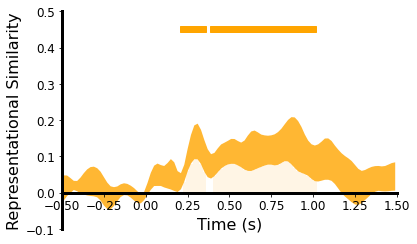

Position RSA-based Decoding Results!


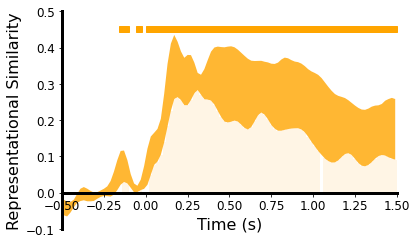

In [6]:
# plot orientation decoding results
print("Orientation RSA-based Decoding Results!")
plot_tbytsim_withstats(Sim_ori_ERP, start_time=-0.5, end_time=1.5, color='orange', lim=[-0.1, 0.5])

# plot position decoding results
print("Position RSA-based Decoding Results!")
plot_tbytsim_withstats(Sim_pos_ERP, start_time=-0.5, end_time=1.5, color='orange', lim=[-0.1, 0.5])